Notebook purpose: evaluate how efficiently we could search for catalysts using the ML model under various constraints.

The most conspicuous constraint is to find a set number of active catalysts without any unnecessary DFT calculations
What is unnecessary? --> 100% of O2 binding calculations are to actual binding sites
So we can accept a model with lower accuracy as long as it has no false positives --> only a small penalty for false negatives

Let's say we're only willing to run 5 DFT O2 binding calculations, and we want basically all of them to show that we found active sites. We'd probably want each of these to be per catalyst, to show that we've found 5 unique active catalysts. Assuming we're working with 10% of the data as a "test" set, that's about 27 calalysts, so we want to pick the ones that the model is most confident have at least 1 site that binds O2.

Really, this is a question of whether the active sites for a set of catalysts are most likely to actually be binding
Can order by log-loss and take that as an estimate of uncertainty (is that a fair expectation?)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import GroupShuffleSplit

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix

plt.rcParams.update({'font.size': 20})

In [2]:
from ngcc_ml import data_tools
from ngcc_ml import skl_tools

In [3]:
def search_for_active_catalysts(df_catalysts, order_col, feature_cols, target_col="Doesitbind", find_num=10):
    """
    df_catalysts (pandas dataframe): catalysts to search
    order_col (str): column name to sort catalysts by. Expected for predict_proba or random values
    """
    df_sort = df_catalysts.sort_values(by=order_col, ascending=False)
    found_list = []
    count = 0
    for index, row in df_sort.iterrows():
        if row["Catalyst Name"] not in found_list:
            if row[target_col] == 1:
                found_list.append(row["Catalyst Name"])
            count += 1
            assert len(found_list) <= find_num
            if len(found_list) == find_num:
                break
    return found_list, count

In [4]:
df = pd.read_csv("/home/nricke/work/ngcc_ml/DidItBindv5.csv")
df["Doesitbind"] = df["Doesitbind"].astype("int")

In [5]:
feature_cols = {"SpinDensity", "ChElPGNeutralCharge", "ChargeDifference", "IonizationEnergy", "OrthoOrPara", "Meta", "FartherThanPara", "DistanceToN", "AverageBondLength",  "NumberOfHydrogens", "IsInRingSize6", "IsInRingSize5", "NeighborSpinDensity", 'NeighborChElPGCharge', 'NeighborChargeDifference', "AromaticExtent", "RingEdge", "NumNitrogens", "NumHeteroatoms", "charge", "atom_plane_deviation", "ring_plane_deviation", "ring_nitrogens"}
not_scaled_cols = {"OrthoOrPara", "Meta", "FartherThanPara", "NumberOfHydrogens", "IsInRingSize6", "IsInRingSize5", "RingEdge", "NumNitrogens", "NumHeteroatoms", "ring_nitrogens", "charge"}
df_scale = data_tools.process_data(df, scaledCols=list(feature_cols - not_scaled_cols))

In [6]:
rfc = RandomForestClassifier(n_estimators=1000, max_depth=100, class_weight={0:0.5, 1:0.5})
gkf_scores, df_gkf = skl_tools.group_kfold_evaluate(rfc, df_scale, feature_cols, target_col="Doesitbind")
print("score stdev:", np.std(gkf_scores))

Accuracy of RFC on test set: 0.96
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.95
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.94
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.96
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.96
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.96
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.95
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.96
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.94
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.95
Accuracy of RFC on training set: 1.00
mean: 0.9524526577228238
score stdev: 0.007146542483848826


In [7]:
df_gkf.to_csv("df_classify_GroupKFold.csv")
gkf_scores

[0.9615384615384616,
 0.9495192307692307,
 0.9423076923076923,
 0.9560975609756097,
 0.9609756097560975,
 0.9585365853658536,
 0.9495192307692307,
 0.9567307692307693,
 0.9399038461538461,
 0.9493975903614458]

In [8]:
calc_class, calc_rand, calc_ratio = [], [], []

for ii in range(30):
    rfc = RandomForestClassifier(n_estimators=1000, max_depth=100, class_weight={0:0.5, 1:0.5})
    gkf_scores, df_gkf_ts = skl_tools.group_kfold_evaluate(rfc, df_scale, feature_cols, target_col="Doesitbind")
    df_gkf_ts = df_gkf_ts.assign(random_ordering=np.random.rand(df_gkf_ts.shape[0]))
    l_O2, c_O2 = search_for_active_catalysts(df_gkf_ts, order_col="random_ordering", feature_cols=feature_cols, find_num=100)
    print(len(l_O2), c_O2)
    l_t, c_t = search_for_active_catalysts(df_gkf_ts, order_col="Doesitbind_predproba", feature_cols=feature_cols, find_num=100)
    print(len(l_t), c_t)
    calc_class.append(c_O2)
    calc_rand.append(c_t)
    calc_ratio.append(c_t/c_O2)

Accuracy of RFC on test set: 0.96
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.96
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.94
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.96
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.96
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.96
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.95
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.95
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.94
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.95
Accuracy of RFC on training set: 1.00
mean: 0.9534241704152444
100 551
100 101
Accuracy of RFC on test set: 0.96
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.95
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.94
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test

KeyboardInterrupt: 

In [10]:
#df_gkf_ts = df_gkf.sort_values(by="Doesitbind_predproba", ascending=False)[["Catalyst Name", "Atom Number", "Doesitbind", "Doesitbind_pred", "Doesitbind_predproba"]]

In [8]:
print(calc_class)
print(calc_rand)
print(calc_ratio)
print(np.mean(calc_class), np.std(calc_class))
print(np.mean(calc_rand), np.std(calc_rand))
print(np.mean(calc_ratio), np.std(calc_ratio))

[615, 608, 695, 594, 556, 644, 613, 570, 604, 528, 578, 570, 630, 663, 574, 564, 610, 578, 566, 619, 631, 642, 562, 520, 558, 495, 607, 578, 615, 617]
[101, 101, 102, 101, 101, 102, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 102, 101, 101, 101, 102, 101, 101, 101, 101, 101, 101, 102, 101]
[0.16422764227642275, 0.16611842105263158, 0.14676258992805755, 0.17003367003367004, 0.18165467625899281, 0.15838509316770186, 0.16476345840130505, 0.17719298245614035, 0.1672185430463576, 0.19128787878787878, 0.17474048442906576, 0.17719298245614035, 0.16031746031746033, 0.15233785822021115, 0.1759581881533101, 0.17907801418439717, 0.16557377049180327, 0.17647058823529413, 0.1784452296819788, 0.1631663974151858, 0.1600633914421553, 0.1588785046728972, 0.1797153024911032, 0.19423076923076923, 0.18100358422939067, 0.20404040404040405, 0.16639209225700163, 0.17474048442906576, 0.16585365853658537, 0.16369529983792544]
593.4666666666667 42.008517654822754
101.16666666666667 0.3726779962499649

Now that we've seen this is relatively successful in this framework, the next step is to do a head-to-head search comparison.
For a set of C catalysts, search until a subset A are found that are active, with the goal of checking O2 binding for as few as possible.
This is really quite similar to above, but we just want to keep track of slightly different metrics. For each group, we now want to instead ask 

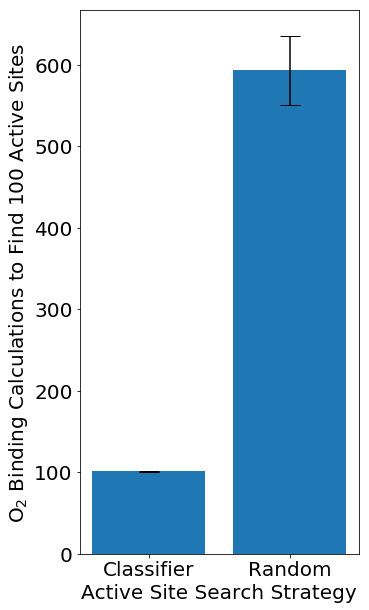

In [21]:
fig = plt.figure(figsize=(5,10))
ax = plt.subplot(111)
plt.bar(np.arange(2)+1, [np.mean(calc_rand), np.mean(calc_class)], tick_label=["Classifier", "Random"], yerr=[np.std(calc_rand), np.std(calc_class)], capsize=10)
plt.xlabel("Active Site Search Strategy")
plt.ylabel(r"O$_2$ Binding Calculations to Find 100 Active Sites")
plt.savefig("ClassificationSpeedup.png")

In [13]:

df_ts

,Catalyst Name,Doesitbind,Doesitbind_pred,Doesitbind_predproba
2487,sf252x0,1,1,1.000
3319,sf45x0,1,1,1.000
2217,sf238x0,1,1,1.000
3697,sf64x0,1,1,1.000
967,sf158x0,1,1,1.000
3644,sf61x0,1,1,1.000
3903,sf80x0,1,1,1.000
1812,sf208x0,1,1,1.000
2316,sf243x0,1,1,0.999
704,sf146x0,1,1,0.999


In [15]:
df_ts.iloc[0].random_ordering

0.22637466711018506

In [ ]:
l, c = search_for_active_catalysts(df_ts, order_col="random_ordering", feature_cols=feature_cols, find_num=100)
print(len(l))
print(c)

In [ ]:
df_test_all = df_test_all.drop_duplicates()

In [ ]:
df_test_all = df_test_all.assign(random_ordering=np.random.rand(df_test_all.shape[0]))

100 607
100 101
